In [ ]:
# notebook that goes through and produces the same plot regional_plot_script.py

In [1]:
import os
os.getcwd()

'/data/ziz/not-backed-up/bhe/Rmap/regional_plots'

In [2]:
import os
os.chdir('..') # assume cwd was regional_plots
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [3]:
today="2021-03-07_region"
website_folder="docs/assets/data"

In [4]:
regions = pd.read_csv("data/nhs_regions.csv", header=0).iloc[:,0].to_list()
cpred_df = pd.read_csv(f"{website_folder}/{today}/Cpred_region.csv")
cproj_df = pd.read_csv(f"{website_folder}/{today}/Cproj_region.csv")
cactual_df = pd.read_csv(f"{website_folder}/region_site_data.csv")
rt_df = pd.read_csv(f"{website_folder}/{today}/Rt_region.csv")


In [5]:
def subset_df(df, col, val):
    condition = (df[col] == val)
    return df.loc[condition]

In [6]:
from matplotlib.dates import date2num as d2n
month_dict = {"01": "Jan", "02": "Feb", "03": "Mar", "04": "Apr", "05": "May", "06": "Jun", "07": "Jul", "08": "Aug", "09": "Sep", "10": "Oct", "11": "Nov", "12": "Dec"}

In [7]:
def get_xticks_and_xlabels(dfs, col="Date"):
    date_df = pd.concat([df["Date"] for df in dfs])
    # return date_df
    dates = date_df.unique()
    months = [month_dict[d.split("-")[1]] for d in dates] 
    date_nums = d2n(dates)
    indx = [d.split("-")[-1] == "01" for d in dates]
    indx = [i for i,x in enumerate(indx) if x]
    date_nums = date_nums[indx]
    months = [months[id] for id in indx]
    return date_nums, months

In [8]:
def make_cases_plot(ax, region, cpred_df, cproj_df, actual_case_df, end=today, model_col="royalblue", actual_col="dodgerblue"):
    ax.set_title(f"{region} cases")
    ax.set_ylabel(f"Daily case count")
    # ax.set_xlabel(f"Date")
    reg_cpred_df = subset_df(cpred_df, "area", region)
    reg_cproj_df = subset_df(cproj_df, "area", region)
    reg_actual_df = subset_df(actual_case_df, "NHS_Region", region)
    ax.plot(d2n(reg_cpred_df["Date"]), reg_cpred_df["C_50"], color=model_col)
    ax.fill_between(d2n(reg_cpred_df["Date"]), reg_cpred_df["C_25"], reg_cpred_df["C_75"], color=model_col, alpha=0.5)
    ax.fill_between(d2n(reg_cpred_df["Date"]), reg_cpred_df["C_025"], reg_cpred_df["C_975"], color=model_col, alpha=0.25)
    ax.axvline(d2n(reg_cpred_df["Date"])[-1], ls="--", color=model_col, alpha=0.7)

    ax.plot(d2n(reg_cproj_df["Date"]), reg_cproj_df["C_50"], color="k", ls="--")
    ax.fill_between(d2n(reg_cproj_df["Date"]), reg_cproj_df["C_25"], reg_cproj_df["C_75"], color="k", alpha=0.5)
    ax.fill_between(d2n(reg_cproj_df["Date"]), reg_cproj_df["C_025"], reg_cproj_df["C_975"], color="k", alpha=0.25)

    ax.plot(d2n(reg_actual_df["Date"]), reg_actual_df["cases_new"], color=actual_col, alpha=0.4)
    xticks, xlabels = get_xticks_and_xlabels([reg_cpred_df, reg_cproj_df, reg_actual_df])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

def make_r_plot(ax, region, rt_df, actual_case_df, end=today, model_col="royalblue", tick_spacing=0.5):
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(f"{region} Rt")
    ax.set_ylabel(f"Rt")
    # ax.set_xlabel(f"Date")
    reg_rt_df = subset_df(rt_df, "area", region)
    
    inferred_df = reg_rt_df.loc[reg_rt_df["provenance"] == "inferred"]
    projected_df = reg_rt_df.loc[reg_rt_df["provenance"] == "projected"]
    ax.axvline(d2n(inferred_df["Date"])[-1], ls="--", color=model_col, alpha=0.7)
    ax.axhline(1.0, ls="--", color="k", alpha=0.9)
    ax.plot(d2n(inferred_df["Date"]), inferred_df["Rt_50"], color=model_col)
    ax.fill_between(d2n(inferred_df["Date"]), inferred_df["Rt_25"], inferred_df["Rt_75"], color=model_col, alpha=0.5)
    ax.fill_between(d2n(inferred_df["Date"]), inferred_df["Rt_2_5"], inferred_df["Rt_97_5"], color=model_col, alpha=0.25)

    ax.plot(d2n(projected_df["Date"]), projected_df["Rt_50"], color="k", ls="--")
    ax.fill_between(d2n(projected_df["Date"]), projected_df["Rt_25"], projected_df["Rt_75"], color="k", alpha=0.5)
    ax.fill_between(d2n(projected_df["Date"]), projected_df["Rt_2_5"], projected_df["Rt_97_5"], color="k", alpha=0.25)

    xticks, xlabels = get_xticks_and_xlabels([reg_rt_df, actual_case_df])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)



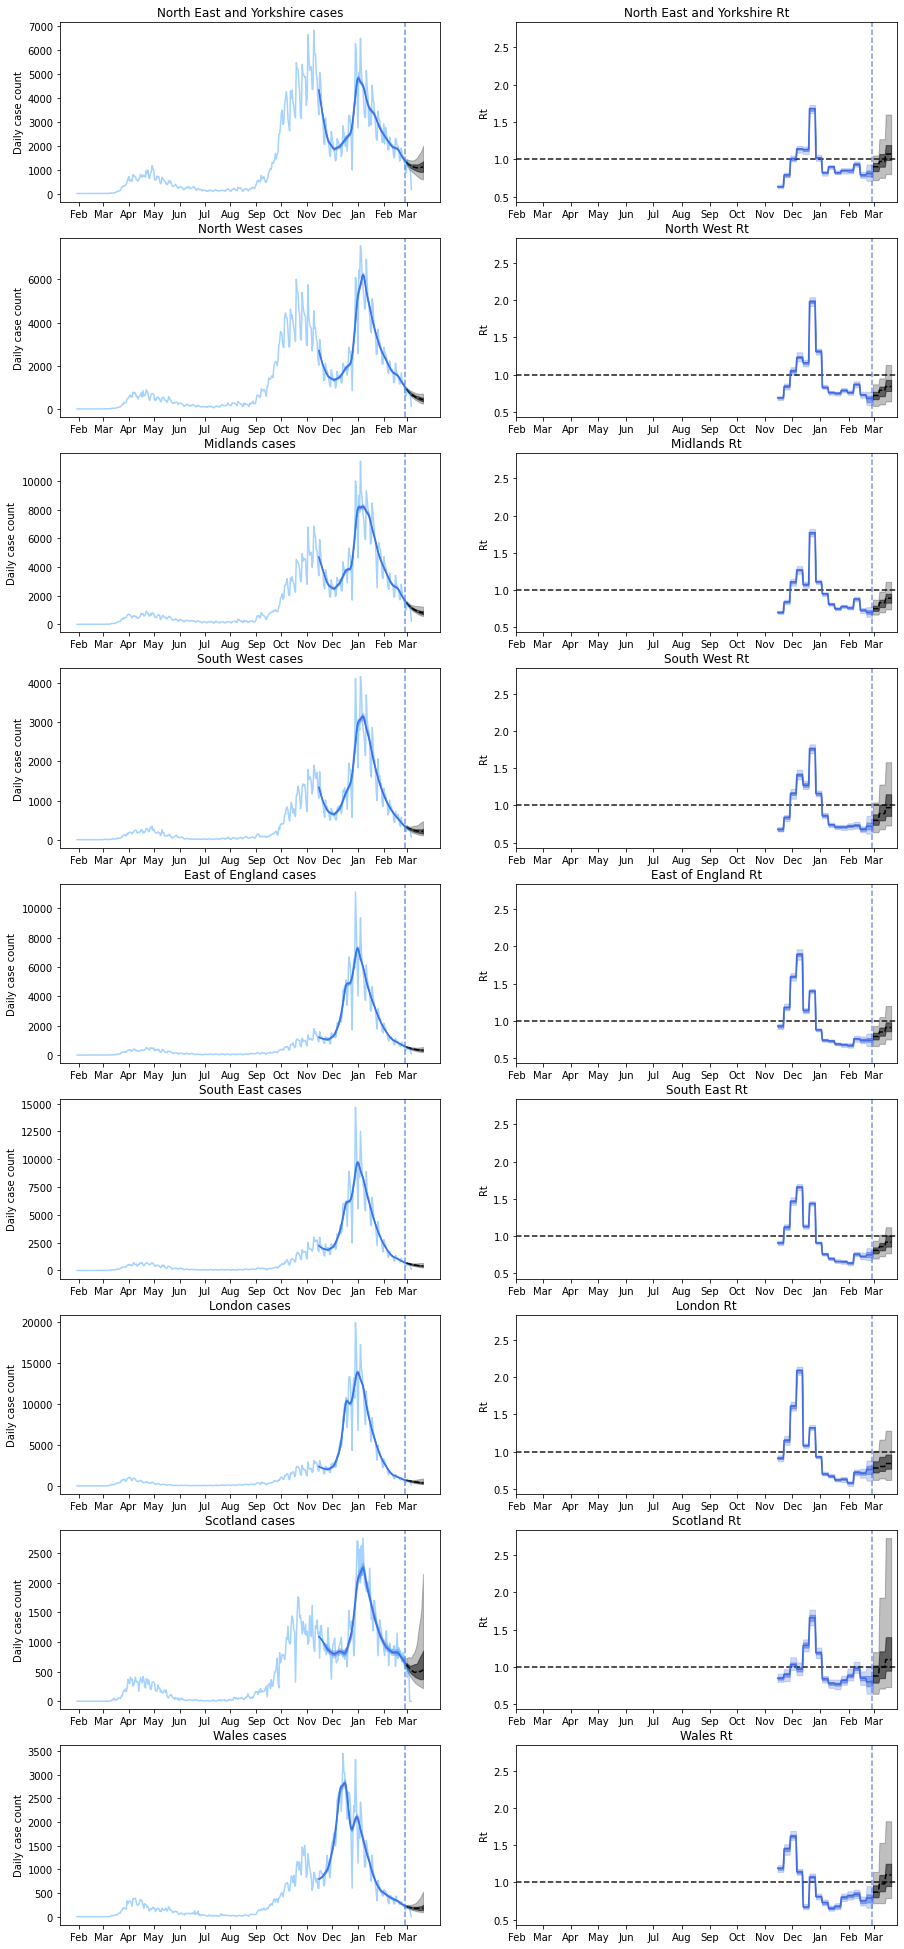

In [9]:
fig, axs = plt.subplots(9, 2, figsize=(15,35))
ax_list = [axs[r_id, 1] for r_id, _ in enumerate(regions)]
ax_list[0].get_shared_y_axes().join(*ax_list)
for r_id, region in enumerate(regions):
    for id in range(2):
        ax = axs[r_id, id]
        if id==0:
            make_cases_plot(ax, region, cpred_df, cproj_df, cactual_df)
        if id==1:
            make_r_plot(ax, region, rt_df, cactual_df)
# for ax in axs.reshape(-1):
#     ax.set_ylim(bottom=0)
fig.savefig(f"{website_folder}/{today}/regional_plot.pdf")
